# ONNX FFTs

Implementation of a couple of variations of FFT (see [FFT](https://www.tensorflow.org/xla/operation_semantics#fft) in ONNX.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

In [3]:
%load_ext mlprodict

## Signature

We try to use function [FFT](https://www.tensorflow.org/xla/operation_semantics#fft) or [torch.fft.fftn](https://pytorch.org/docs/stable/generated/torch.fft.fftn.html#torch.fft.fftn).

In [4]:
import numpy
from numpy.testing import assert_almost_equal

def numpy_fftn(x, fft_type, fft_length, axes):
    """
    Implements FFT

    :param x: input
    :param fft_type: string (see below)
    :param fft_length: length on each axis of axes
    :param axes: axes
    :return: result
    
    * `'FFT`': complex-to-complex FFT. Shape is unchanged.
    * `'IFFT`': Inverse complex-to-complex FFT. Shape is unchanged.
    * `'RFFT`': Forward real-to-complex FFT.
      Shape of the innermost axis is reduced to fft_length[-1] // 2 + 1 if fft_length[-1]
      is a non-zero value, omitting the reversed conjugate part of 
      the transformed signal beyond the Nyquist frequency.
    * `'IRFFT`': Inverse real-to-complex FFT (ie takes complex, returns real).
      Shape of the innermost axis is expanded to fft_length[-1] if fft_length[-1] 
      is a non-zero value, inferring the part of the transformed signal beyond the Nyquist
      frequency from the reverse conjugate of the 1 to fft_length[-1] // 2 + 1 entries.
    """
    if fft_type == 'FFT':
        return numpy.fft.fftn(x, fft_length, axes=axes)
    raise NotImplementedError("Not implemented for fft_type=%r." % fft_type)
    

def test_fct(fct1, fct2, fft_type='FFT', decimal=5):
    dims = [[4,4,4,4],
            [4,5,6,7]]
    lengths_axes = [([2, 2, 2, 2], None),
                    ([2, 6, 7, 2], None),
                    ([2, 3, 4, 5], None),
                    ([2], [3]),
                    ([3], [2])]
    n_test = 0
    for ndim in range(1, 5):
        for dim in dims:
            for length, axes in lengths_axes:
                if axes is None:
                    axes = range(ndim)
                axes = [min(ndim - 1, a) for a in axes]
                di = dim[:ndim]
                le = length[:ndim]
                mat = numpy.random.randn(*di).astype(numpy.float32)
                try:
                    v1 = fct1(mat, fft_type, le, axes=axes)
                except Exception as e:
                    raise AssertionError(
                        "Unable to run %r mat.shape=%r ndim=%r fft_type=%r le=%r "
                        "axes=%r exc=%r" %(
                            fct1, mat.shape, ndim, fft_type, le, axes, e))
                v2 = fct2(mat, fft_type, le, axes=axes)
                try:
                    assert_almost_equal(v1, v2, decimal=decimal)
                except AssertionError as e:
                    raise AssertionError(
                        "Failure mat.shape=%r, fft_type=%r, fft_length=%r" % (
                            mat.shape, fft_type, le)) from e
                n_test += 1
    return n_test
                    
test_fct(numpy_fftn, numpy_fftn)

40

In [5]:
import torch

def torch_fftn(x, fft_type, fft_length, axes):
    xt = torch.tensor(x)
    if fft_type == 'FFT':
        return torch.fft.fftn(xt, fft_length, axes).cpu().detach().numpy()
    
test_fct(numpy_fftn, torch_fftn)

40

## Numpy implementation

In [6]:
import numpy


def _dft_cst(N, fft_length, dtype):
    def _arange(dim, dtype, resh):
        return numpy.arange(dim).astype(dtype).reshape(resh)

    def _prod(n, k):
        return (-2j * numpy.pi * k / fft_length) * n

    def _exp(m):
        return numpy.exp(m)
    
    n = _arange(N, dtype, (-1, 1))
    k = _arange(fft_length, dtype, (1, -1))
    M = _exp(_prod(n, k))
    return M


def custom_fft(x, fft_type, length, axis, dft_fct=None):
    # https://github.com/numpy/numpy/blob/4adc87dff15a247e417d50f10cc4def8e1c17a03/numpy/fft/_pocketfft.py#L56
    if dft_fct is None:
        dft_fct = _dft_cst
    if fft_type == 'FFT':
        if x.shape[axis] > length:
            # fft_length > shape on the same axis
            # the matrix is shortened
            slices = [slice(None)] * len(x.shape)
            slices[axis] = slice(0, length)
            new_x = x[tuple(slices)]
        elif x.shape[axis] == length:
            new_x = x
        else:
            # other, the matrix is completed with zeros
            shape = list(x.shape)
            shape[axis] = length
            slices = [slice(None)] * len(x.shape)
            slices[axis] = slice(0, length)
            zeros = numpy.zeros(tuple(shape), dtype=x.dtype)
            index = [slice(0, i) for i in x.shape]
            zeros[tuple(index)] = x
            new_x = zeros

        cst = dft_fct(new_x.shape[axis], length, x.dtype)
        perm = numpy.arange(len(x.shape)).tolist()        
        if perm[axis] == perm[-1]:
            res = numpy.matmul(new_x, cst).transpose(perm)
        else:
            perm[axis], perm[-1] = perm[-1], perm[axis]            
            rest = new_x.transpose(perm)
            res = numpy.matmul(rest, cst).transpose(perm)
            perm[axis], perm[0] = perm[0], perm[axis]
        return res
    raise ValueError("Unexpected value for fft_type=%r." % fft_type)


def custom_fftn(x, fft_type, fft_length, axes, dft_fct=None):
    if len(axes) != len(fft_length):
        raise ValueError("Length mismatch axes=%r, fft_length=%r." % (
           axes, fft_length))
    if fft_type == 'FFT':
        res = x
        for i in range(len(fft_length) - 1, -1, -1):
            length = fft_length[i]
            axis = axes[i]
            res = custom_fft(res, fft_type, length, axis, dft_fct=dft_fct)
        return res
    raise ValueError("Unexpected value for fft_type=%r." % fft_type)

    
img = 1j
shape = (4, )
fft_length = [5,]
axes = [0]
rnd = numpy.random.randn(*shape) + numpy.random.randn(*shape) * img
custom_fftn(rnd, 'FFT', fft_length, axes), numpy_fftn(rnd, 'FFT', fft_length, axes)
assert_almost_equal(custom_fftn(rnd, 'FFT', fft_length, axes),
                    numpy_fftn(rnd, 'FFT', fft_length, axes), decimal=5)

img = 1j
shape = (4, 3)
fft_length = [3, 2]
axes = [0, 1]
rnd = numpy.random.randn(*shape) + numpy.random.randn(*shape) * img
custom_fftn(rnd, 'FFT', fft_length, axes), numpy_fftn(rnd, 'FFT', fft_length, axes)
assert_almost_equal(custom_fftn(rnd, 'FFT', fft_length, axes),
                    numpy_fftn(rnd, 'FFT', fft_length, axes), decimal=5)

In [7]:
test_fct(numpy_fftn, custom_fftn, decimal=4)

40

## Benchmark

In [8]:
from cpyquickhelper.numbers.speed_measure import measure_time
from tqdm import tqdm
from pandas import DataFrame

def benchmark(fcts):
    shape = [4, 90]
    axes = [1]
    rnd = numpy.random.randn(*shape) + numpy.random.randn(*shape) * img

    data = []
    for length in tqdm(range(8, 180, 8)):
        fft_length = [length]
        for name, fct in fcts.items():
            obs = measure_time(lambda: fct(rnd, 'FFT', fft_length, axes),
                               repeat=10, number=10)
            obs['name'] = name
            obs['length'] = length
            data.append(obs)

    df = DataFrame(data)
    return df


df = benchmark({'numpy_fftn': numpy_fftn, 'custom_fftn': custom_fftn, 'torch_fftn': torch_fftn})
piv = df.pivot("length", "name", "average")
piv[:5]

100%|██████████| 22/22 [00:02<00:00,  9.98it/s]


name,custom_fftn,numpy_fftn,torch_fftn
length,,,
8,0.000456,0.000108,0.000558
16,0.000438,0.000090,0.000416
24,0.001177,0.000098,0.000783
32,0.001211,0.000098,0.000367
40,0.001423,0.000103,0.000360


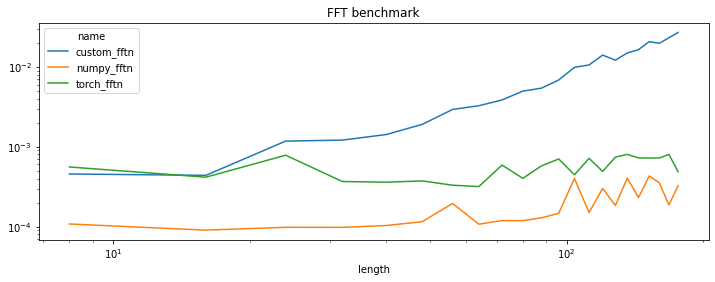

In [9]:
piv.plot(logy=True, logx=True, title="FFT benchmark", figsize=(12, 4));

## Profiling

In [10]:
from pyquickhelper.pycode.profiling import profile2graph, profile

shape = [4, 131]
fft_length = [128]
axes = [1]

def f():
    for i in range(100):
        custom_fftn(rnd, 'FFT', fft_length, axes)

stat, text = profile(f)
gr = profile2graph(stat)
print(gr[0].to_text(fct_width=40))

f                                        --    1    1 -- 0.00010 0.13640 -- <ipython-input-10-0b9ed5a82854>:7:f (f)
    custom_fftn                          --  100  100 -- 0.00041 0.13630 -- <ipython-input-6-36fd258b5be1>:57:custom_fftn (custom_fftn)
        custom_fft                       --  100  100 -- 0.00477 0.13585 -- <ipython-input-6-36fd258b5be1>:20:custom_fft (custom_fft)
            _dft_cst                     --  100  100 -- 0.00034 0.13043 -- <ipython-input-6-36fd258b5be1>:4:_dft_cst (_dft_cst)
                _arange                  --  200  200 -- 0.00024 0.00096 -- <ipython-input-6-36fd258b5be1>:5:_arange (_arange)
                    <method '...objects> --  200  200 -- 0.00027 0.00027 -- ~:0:<method 'astype' of 'numpy.ndarray' objects> (<method 'astype' of 'numpy.ndarray' objects>)
                    <method '...objects> --  200  200 -- 0.00016 0.00016 -- ~:0:<method 'reshape' of 'numpy.ndarray' objects> (<method 'reshape' of 'numpy.ndarray' objects>)
            

We can see that function `_dft_cst` is the bottle neck and more precisely the exponential. We need to use the symmetries of the matrix it builds.

## Faster _dft_cst

The function builds the matrix $M_{nk} = \left( \exp\left(\frac{-2i\pi nk}{K}\right) \right)_{nk}$ where $1 \leqslant n \leqslant N$ and $1 \leqslant k \leqslant K$. So it computes powers of the unity roots.

$$
\exp\left(\frac{-2i\pi nk}{K}\right) = \exp\left(\frac{-2i\pi k}{K}\right)^n = \exp\left(\frac{-2i\pi}{K}\right)^{nk}
$$

We use that expression to reduce the number of exponentiels to compute.

In [11]:
import numpy
from numpy.testing import assert_almost_equal

def _dft_cst(N, fft_length, dtype=numpy.float32):
    def _arange(dim, dtype, resh):
        return numpy.arange(dim).astype(dtype).reshape(resh)

    n = _arange(N, dtype, (-1, 1))
    k = _arange(fft_length, dtype, (1, -1))
    M = (-2j * numpy.pi * k / fft_length) * n
    numpy.exp(M, out=M)
    return M


M = _dft_cst(3, 4, numpy.float32)
M.shape, M.dtype

((3, 4), dtype('complex64'))

In [12]:
M = _dft_cst(4, 3, numpy.float64)
M.shape, M.dtype

((4, 3), dtype('complex128'))

In [13]:
M

array([[ 1. +0.00000000e+00j,  1. +0.00000000e+00j,  1. +0.00000000e+00j],
       [ 1. +0.00000000e+00j, -0.5-8.66025404e-01j, -0.5+8.66025404e-01j],
       [ 1. +0.00000000e+00j, -0.5+8.66025404e-01j, -0.5-8.66025404e-01j],
       [ 1. +0.00000000e+00j,  1. +2.44929360e-16j,  1. +4.89858720e-16j]])

In [14]:
def _dft_cst_power(N, fft_length, dtype=numpy.float32):
    if dtype == numpy.float32:
        ctype = numpy.complex64
    else:
        ctype = numpy.complex128
    M = numpy.empty((N, fft_length), dtype=ctype)
    M[0, :] = 1
    M[1, 0] = 1
    root = numpy.exp(numpy.pi / fft_length * (-2j))
    current = root
    M[1, 1] = root
    for i in range(2, M.shape[1]):
        current *= root
        M[1, i] = current
    for i in range(2, M.shape[0]):
        numpy.multiply(M[i-1, :], M[1, :], out=M[i, :])
    return M

M_pow = _dft_cst_power(4, 3, numpy.float64)
M_pow

array([[ 1. +0.00000000e+00j,  1. +0.00000000e+00j,  1. +0.00000000e+00j],
       [ 1. +0.00000000e+00j, -0.5-8.66025404e-01j, -0.5+8.66025404e-01j],
       [ 1. +0.00000000e+00j, -0.5+8.66025404e-01j, -0.5-8.66025404e-01j],
       [ 1. +0.00000000e+00j,  1. +6.10622664e-16j,  1. +1.22124533e-15j]])

In [15]:
assert_almost_equal(M, M_pow)

In [16]:
dims = (10, 15)
assert_almost_equal(_dft_cst(*dims, dtype=numpy.float32), 
                    _dft_cst_power(*dims, dtype=numpy.float32),
                    decimal=5)

## Benchmark again

In [17]:
def custom_fftn_power(*args, **kwargs):
    return custom_fftn(*args, dft_fct=_dft_cst_power, **kwargs)


test_fct(numpy_fftn, custom_fftn_power, decimal=4)

40

In [18]:
df = benchmark({
    'numpy_fftn': numpy_fftn, 'torch_fftn': torch_fftn, 'custom_fftn': custom_fftn, 
    'custom_fftn_power': custom_fftn_power})
piv = df.pivot("length", "name", "average")
piv[:5]

100%|██████████| 22/22 [00:02<00:00,  8.38it/s]


name,custom_fftn,custom_fftn_power,numpy_fftn,torch_fftn
length,,,,
8,0.000652,0.000771,0.000186,0.000529
16,0.000546,0.001110,0.000347,0.000791
24,0.001045,0.000633,0.000243,0.000636
32,0.001008,0.000687,0.000129,0.000348
40,0.001459,0.000868,0.000132,0.000338


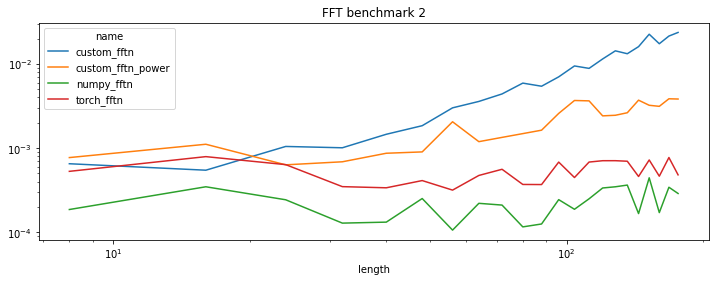

In [19]:
piv.plot(logy=True, logx=True, title="FFT benchmark 2", figsize=(12, 4));

In [20]:
from pyquickhelper.pycode.profiling import profile2graph, profile

shape = [4, 131]
fft_length = [128]
axes = [1]

def f():
    for i in range(100):
        custom_fftn_power(rnd, 'FFT', fft_length, axes)

stat, text = profile(f)
gr = profile2graph(stat)
print(gr[0].to_text(fct_width=40))

f                                        --    1    1 -- 0.00021 0.04622 -- <ipython-input-20-33b1bb0b6440>:7:f (f)
    custom_fftn_power                    --  100  100 -- 0.00021 0.04601 -- <ipython-input-17-d2b4c01c14a6>:1:custom_fftn_power (custom_fftn_power)
        custom_fftn                      --  100  100 -- 0.00070 0.04579 -- <ipython-input-6-36fd258b5be1>:57:custom_fftn (custom_fftn)
            custom_fft                   --  100  100 -- 0.00731 0.04503 -- <ipython-input-6-36fd258b5be1>:20:custom_fft (custom_fft)
                _dft_cst_power           --  100  100 -- 0.03606 0.03625 -- <ipython-input-14-8502f1ddbe1f>:1:_dft_cst_power (_dft_cst_power)
                    <built-in...y.empty> --  100  100 -- 0.00019 0.00019 -- ~:0:<built-in method numpy.empty> (<built-in method numpy.empty>)
                <listcomp>               --  100  100 -- 0.00011 0.00011 -- <ipython-input-6-36fd258b5be1>:40:<listcomp> (<listcomp>)
                <method 'to...' objects> --  100

## Cooley–Tukey FFT algorithm

See [Cooley–Tukey FFT algorithm](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm).

The FFT matrix is defined by the matrix computation $F_{ak} = X_{an} M_{nk}$, then one coefficient is ($1 \leqslant n, k \leqslant K$):

$$
F_{ak} = \sum_n X_{an} M_{nk} = \sum_n X_{an} \exp\left(\frac{-2i\pi}{K}\right)^{nk}
$$

Let's assume K is even, then $\exp\left(\frac{-2i\pi k}{K}\right) = -\exp\left(\frac{-2i\pi \left(k + \frac{K}{2}\right)}{K}\right)$.

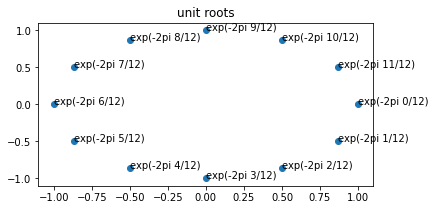

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
a = numpy.arange(0, 12) * (-2 * numpy.pi / 12)
X = numpy.vstack([numpy.cos(a), numpy.sin(a)]).T
ax.plot(X[:, 0], X[:, 1], 'o');
for i in range(0, 12):
    ax.text(X[i, 0], X[i, 1], "exp(-2pi %d/12)" % i)
ax.set_title('unit roots');

Then:

$$
\begin{array}{rcl}
F_{a,k + \frac{K}{2}} &=& \sum_{n=1}^{N} X_{an} \exp\left(\frac{-2i\pi}{K}\right)^{n\left(k + \frac{K}{2}\right)} \\
&=&\sum_{n=1}^{N} X_{an} (-1)^n \exp\left(\frac{-2i\pi}{K}\right)^{nk} \\
&=&\sum_{m=1}^{\frac{N}{2}} X_{a,2m} \exp\left(\frac{-2i\pi}{K}\right)^{2mk} - \sum_{m=1}^{\frac{N}{2}} X_{a,2m-1} \exp\left(\frac{-2i\pi}{K}\right)^{(2m-1)k} \\
&=&\sum_{m=1}^{\frac{N}{2}} X_{a,2m} \exp\left(\frac{-2i\pi}{K}\right)^{2mk} - \sum_{m=1}^{\frac{N}{2}} X_{a,2m-1} \exp\left(\frac{-2i\pi}{K}\right)^{2mk} \exp\left(\frac{-2i\pi}{K}\right)^{-k}
\end{array}
$$

Then:

$$
\begin{array}{rcl}
F_{a,k} + F_{a,k+\frac{K}{2}} &=& 2\sum_{m=1}^{\frac{N}{2}} X_{a,2m}  \exp\left(\frac{-2i\pi}{K}\right)^{2mk}
= 2\sum_{m=1}^{\frac{N}{2}} X_{a,2m}  \exp\left(\frac{-2i\pi}{\frac{K}{2}}\right)^{mk}
\end{array}
$$

In [29]:
def cooley_fft_2p(x, fft_length, p2):
    assert fft_length <= p2
    cst = _dft_cst_power(x.shape[-1], fft_length, x.dtype)
    zeros = numpy.zeros((cst.shape[0], p2), dtype=cst.dtype)
    zeros[:, :fft_length] = cst
    return numpy.matmul(x, zeros)


def cooley_fft_recursive(x, fft_length, p2):
    print("[cooley_fft_recursive]", x.shape, fft_length, p2)
    if x.dtype == numpy.float64:
        dtype = numpy.complex128
    else:
        dtype = numpy.complex64
    if p2 == 1:
        return x.astype(dtype)
    # x.shape[-1] must be a power of two
    if len(x.shape) != 2:
        xs = x.reshape((-1, x.shape[-1]))
    else:
        xs = x
    even = xs[:, ::2]
    odd = xs[:, 1::2]
    p2_2 = p2 // 2
    fft_even = cooley_fft_recursive(even, p2_2, p2_2)
    fft_odd = cooley_fft_recursive(odd, p2_2, p2_2)
    if p2_2 >= 2:
        print("++++++++", xs.shape, even.shape, odd.shape, p2, p2_2)
        print(cooley_fft_2p(even, p2_2, p2_2))
        print(fft_even)
        print("======")
        print(cooley_fft_2p(odd, p2_2, p2_2))
        print(fft_odd)
        print("++++++--")
    
    result = numpy.zeros((xs.shape[0], p2), dtype=dtype)
    for k in range(0, p2_2):
        fact = numpy.exp(-2j * numpy.pi * k / p2)
        todd = fft_odd[:, k] * fact
        result[:, k] = fft_even[:, k] + todd
        result[:, k + p2_2] = fft_even[:, k] - todd

    if fft_length < p2:
        result[:, fft_length:] = 0
        
    print("################1, final", p2, p2_2)
    print('true')
    print(cooley_fft_2p(xs, min(fft_length, p2), p2))
    print('false')
    print(result)
    print("################2, final")
        
    if len(x.shape) != 2:
        return result.reshape(x.shape)
    return result
    

def cooley_fft(xt, fft_length):
    # FFT on the last axis
    if len(xt.shape) == 1:
        x = xt.reshape((1, -1))
    else:
        x = xt
    max_length = max(x.shape[-1], fft_length)
    p2 = 1
    while p2 < max_length:
        p2 *= 2
    new_shape = list(x.shape)
    new_shape[-1] = p2
    bigger = numpy.zeros(new_shape, dtype=x.dtype)
    slices = [slice(0, s) for s in x.shape]
    bigger[tuple(slices)] = x
    
    res1 = cooley_fft_2p(bigger, max_length, p2)
    res2 = cooley_fft_recursive(bigger, max_length, p2)
    print('----------------------', fft_length, p2)
    print(xt)
    print(x)
    print(bigger)
    print("=========")
    print(res1)
    print(res2)
    print('----------------------')
    res = res2
    
    slices[-2] = slice(0, x.shape[-2])
    slices[-1] = slice(0, fft_length)
    if len(xt.shape) == 1:
        return res.ravel()[:fft_length]
    else:
        return res[tuple(slices)]
    

def custom_fft_cooley(x, fft_type, length, axis):
    # https://github.com/numpy/numpy/blob/4adc87dff15a247e417d50f10cc4def8e1c17a03/numpy/fft/_pocketfft.py#L56
    if fft_type == 'FFT':
        if x.shape[axis] > length:
            # fft_length > shape on the same axis
            # the matrix is shortened
            slices = [slice(None)] * len(x.shape)
            slices[axis] = slice(0, length)
            new_x = x[tuple(slices)]
        elif x.shape[axis] == length:
            new_x = x
        else:
            # other, the matrix is completed with zeros
            shape = list(x.shape)
            shape[axis] = length
            slices = [slice(None)] * len(x.shape)
            slices[axis] = slice(0, length)
            zeros = numpy.zeros(tuple(shape), dtype=x.dtype)
            index = [slice(0, i) for i in x.shape]
            zeros[tuple(index)] = x
            new_x = zeros

        perm = numpy.arange(len(x.shape)).tolist()        
        if perm[axis] == perm[-1]:
            res = cooley_fft(new_x, length).transpose(perm)
        else:
            perm[axis], perm[-1] = perm[-1], perm[axis]            
            rest = new_x.transpose(perm)
            res = cooley_fft(rest, length).transpose(perm)
            perm[axis], perm[0] = perm[0], perm[axis]
        return res
    raise ValueError("Unexpected value for fft_type=%r." % fft_type)


def custom_fftn_cooley(x, fft_type, fft_length, axes):
    if len(axes) != len(fft_length):
        raise ValueError("Length mismatch axes=%r, fft_length=%r." % (
           axes, fft_length))
    if fft_type == 'FFT':
        res = x
        for i in range(len(fft_length) - 1, -1, -1):
            length = fft_length[i]
            axis = axes[i]
            res = custom_fft_cooley(res, fft_type, length, axis)
        return res
    raise ValueError("Unexpected value for fft_type=%r." % fft_type)

    
img = 1j
shape = (4, )
fft_length = [3,]
axes = [0]
rnd = numpy.random.randn(*shape) + numpy.random.randn(*shape) * img
#custom_fftn_cooley(rnd, 'FFT', fft_length, axes), numpy_fftn(rnd, 'FFT', fft_length, axes)
assert_almost_equal(custom_fftn_cooley(rnd, 'FFT', fft_length, axes),
                    numpy_fftn(rnd, 'FFT', fft_length, axes),
                    decimal=5)
test_fct(numpy_fftn, custom_fftn_cooley)

[cooley_fft_recursive] (1, 4) 3 4
[cooley_fft_recursive] (1, 2) 2 2
[cooley_fft_recursive] (1, 1) 1 1
[cooley_fft_recursive] (1, 1) 1 1
################1, final 2 1
true
[[ 0.76209912-1.41120738j -0.19828965-2.31746686j]]
false
[[ 0.76209915-1.4112073j -0.19828966-2.3174667j]]
################2, final
[cooley_fft_recursive] (1, 2) 2 2
[cooley_fft_recursive] (1, 1) 1 1
[cooley_fft_recursive] (1, 1) 1 1
################1, final 2 1
true
[[-0.68436125+1.23406123j -0.68436125+1.23406123j]]
false
[[-0.6843613+1.2340612j -0.6843613+1.2340612j]]
################2, final
++++++++ (1, 4) (1, 2) (1, 2) 4 2
[[ 0.76209912-1.41120738j -0.19828965-2.31746686j]]
[[ 0.76209915-1.4112073j -0.19828966-2.3174667j]]
[[-0.68436125+1.23406123j -0.68436125+1.23406123j]]
[[-0.6843613+1.2340612j -0.6843613+1.2340612j]]
++++++--
################1, final 4 2
true
[[ 0.07773787-0.17714616j  1.06029468-1.69939784j -0.29231834-3.71646737j
   0.        +0.j        ]]
false
[[0.07773787-0.17714608j 1.0357716 -1.63310

AssertionError: 
Arrays are not almost equal to 5 decimals
 ACTUAL: array([0.07773787-0.17714608j, 1.0357716 -1.6331055j ,
       1.4464605 -2.6452684j ], dtype=complex64)
 DESIRED: array([ 0.07773787-0.17714616j,  1.06029468-1.69939784j,
       -0.29231834-3.71646737j])